## Locally connected layer
- 데이터를 나눠 히든레이어에 일부만 연결한다.
- 연결점으로 add, concat 사용

In [9]:
# 라이브러리
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [10]:
# 데이터 불러오기
data = pd.read_csv('https://raw.githubusercontent.com/DrKAI/dataset/main/breast_cancer.csv')
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Malignant


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

- 각 특징별로 mean(평균값), error(표준편차 값), worst(가장 큰 3개의 평균)로 나누어져있음

----

### 데이터 전처리
- x,y 선언
- train,test 나누기
- y = [0,1]
- x 특징별로 나누기

In [12]:
data['target'].value_counts()

Benign       357
Malignant    212
Name: target, dtype: int64

In [8]:
# y : 0,1 변환
data.loc[data['target']=='Benign', 'target'] = 0
data.loc[data['target']=='Malignant', 'target'] = 1 # loc로 바꾸면 object

data['target'] = data['target'].astype(float)       # float으로 바꿔줘야 fit에서 가능

In [13]:
# 같은 0,1 변환
data['target'] = data['target'].map({'Benign':0, 'Malignant':1})
data['target'].value_counts()

0    357
1    212
Name: target, dtype: int64

In [14]:
# x,y 선언
y = data['target']
x = data.drop('target', axis=1)

In [15]:
# train,test 나누기
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,
                                                 test_size=0.2,
                                                 random_state=2022)
x_train.shape, y_train.shape

((455, 30), (455,))

In [21]:
x.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [16]:
# x : 특징별로 나누기
radius = x_train[['mean radius', 'radius error', 'worst radius']]
texture = x_train[['mean texture', 'texture error', 'worst texture']]
perimeter = x_train[['mean perimeter', 'perimeter error', 'worst perimeter']]
area = x_train[['mean area', 'area error', 'worst area']]
smoothness = x_train[['mean smoothness', 'smoothness error', 'worst smoothness']]
compactness = x_train[['mean compactness', 'compactness error', 'worst compactness']]
concavity = x_train[['mean concavity', 'concavity error', 'worst concavity']]
concave_points = x_train[['mean concave points', 'concave points error', 'worst concave points']]
symmetry = x_train[['mean symmetry', 'symmetry error', 'worst symmetry']]
fractal_dimension = x_train[['mean fractal dimension', 'fractal dimension error', 'worst fractal dimension']]


In [17]:
radius_test = x_test[['mean radius', 'radius error', 'worst radius']]
texture_test = x_test[['mean texture', 'texture error', 'worst texture']]
perimeter_test = x_test[['mean perimeter', 'perimeter error', 'worst perimeter']]
area_test = x_test[['mean area', 'area error', 'worst area']]
smoothness_test = x_test[['mean smoothness', 'smoothness error', 'worst smoothness']]
compactness_test = x_test[['mean compactness', 'compactness error', 'worst compactness']]
concavity_test = x_test[['mean concavity', 'concavity error', 'worst concavity']]
concave_points_test = x_test[['mean concave points', 'concave points error', 'worst concave points']]
symmetry_test = x_test[['mean symmetry', 'symmetry error', 'worst symmetry']]
fractal_dimension_test = x_test[['mean fractal dimension', 'fractal dimension error', 'worst fractal dimension']]


----

### 모델링
- 각 특징별 히든레이어(노드 12개)
- 특징별 히든레이어 Add로 통합
- Add와 통합 Input을 concat
- concat에 히든레이어추가 (노드 128개)

In [22]:
radius.shape, x_train.shape, y_train.shape

((455, 3), (455, 30), (455,))

In [24]:
# 청소
keras.backend.clear_session()

# 모델 연결
il_full = keras.layers.Input(shape=(30,))

il_radius = keras.layers.Input(shape=(3,), name='il_radius')         # 1
hl_radius = keras.layers.Dense(12, activation='relu')(il_radius)

il_texture = keras.layers.Input(shape=(3,), name='il_texture')       # 2
hl_texture = keras.layers.Dense(12, activation='relu')(il_texture)

il_perimeter = keras.layers.Input(shape=(3,), name='il_perimeter')   # 3
hl_perimeter = keras.layers.Dense(12, activation='relu')(il_perimeter)

il_area = keras.layers.Input(shape=(3,), name='area')                # 4
hl_area = keras.layers.Dense(12, activation='relu')(il_area)

il_smoothness = keras.layers.Input(shape=(3,), name='smoothness')    # 5
hl_smoothness = keras.layers.Dense(12, activation='relu')(il_smoothness)

il_compactness = keras.layers.Input(shape=(3,), name='compactness')  # 6
hl_compactness = keras.layers.Dense(12, activation='relu')(il_compactness)

il_concavity = keras.layers.Input(shape=(3,), name='concavity')      # 7 
hl_concavity = keras.layers.Dense(12, activation='relu')(il_concavity)

il_concave_points = keras.layers.Input(shape=(3,), name='concave_points')  # 8
hl_concave_points = keras.layers.Dense(12, activation='relu')(il_concave_points)

il_symmetry = keras.layers.Input(shape=(3,), name='symmetry')        # 9
hl_symmetry = keras.layers.Dense(12, activation='relu')(il_symmetry)

il_fractal_dimension = keras.layers.Input(shape=(3,), name='fractal_dimension')  # 10
hl_fractal_dimension = keras.layers.Dense(12, activation='relu')(il_fractal_dimension)

add = keras.layers.Add()([hl_radius, 
                          hl_texture, 
                          hl_perimeter,
                          hl_area, 
                          hl_smoothness, 
                          hl_compactness,
                          hl_concavity,
                          hl_concave_points,
                          hl_symmetry,
                          hl_fractal_dimension])

cl = keras.layers.Concatenate()([add, il_full])
hl = keras.layers.Dense(128, activation='relu')(cl)

ol = keras.layers.Dense(1, activation='sigmoid')(hl)

input_names = [il_full, il_radius, il_texture, il_perimeter, il_area, 
               il_smoothness, il_compactness, il_concavity, il_concave_points,
               il_symmetry, il_fractal_dimension]

# 모델 선언
model = keras.models.Model(input_names, ol)

# 모델 설정
model.compile(loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'],
              optimizer=keras.optimizers.Adam(0.001))

# 모델 요약
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 il_radius (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 il_texture (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 il_perimeter (InputLayer)      [(None, 3)]          0           []                               
                                                                                                  
 area (InputLayer)              [(None, 3)]          0           []                               
                                                                                              

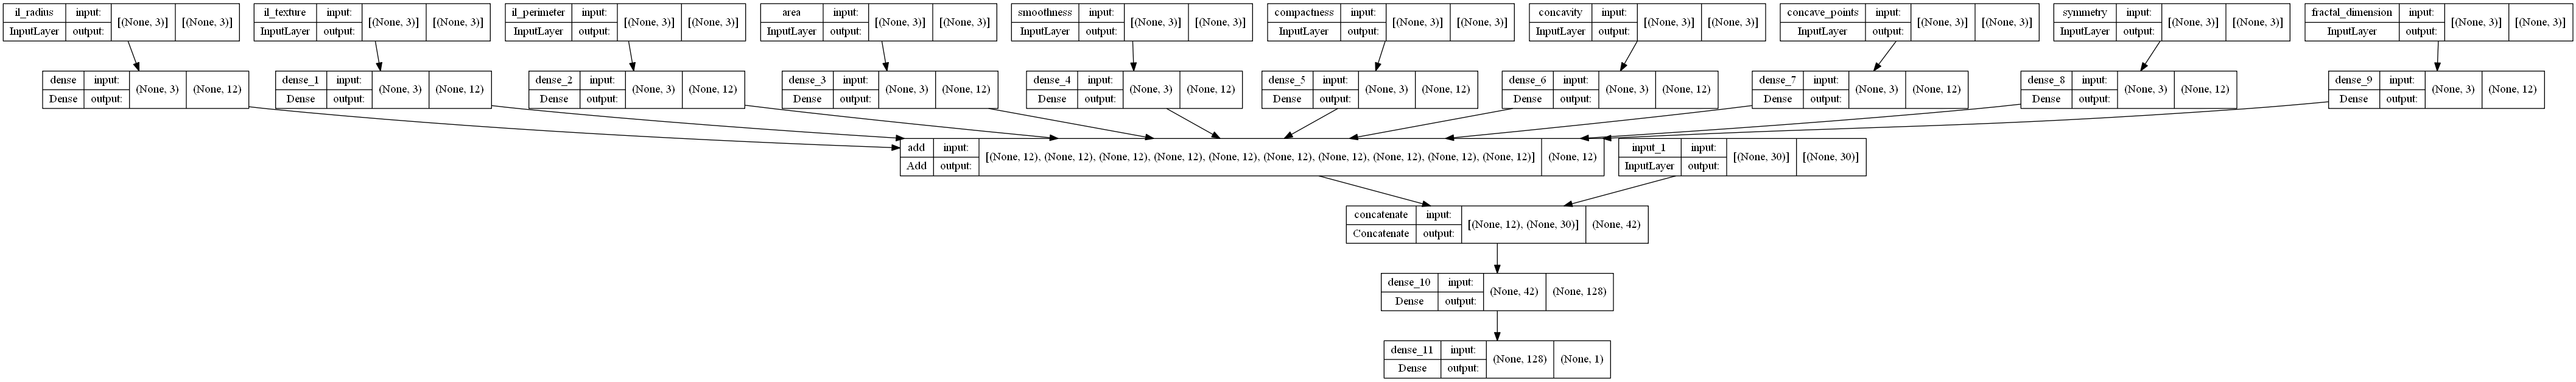

In [27]:
# 모델 시각화
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

----

### 모델학습
- x_train에 나눠준 11개 모두 들어가야함.

In [28]:
train_list = [x_train, radius, texture, 
              perimeter, area, smoothness, 
              compactness, concavity, 
              concave_points, symmetry, fractal_dimension]

In [29]:
test_list = [x_test, radius_test, texture_test, 
              perimeter_test, area_test, smoothness_test, 
              compactness_test, concavity_test, 
              concave_points_test, symmetry_test, fractal_dimension_test]

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)


model.fit(train_list, y_train,
          epochs=2500, verbose=1, validation_split=0.1, callbacks=[es])

Epoch 1/2500
13/13 [==============================] - 1s 35ms/step - loss: 21.8284 - accuracy: 0.4474 - val_loss: 1.4606 - val_accuracy: 0.8913
Epoch 2/2500
13/13 [==============================] - 0s 5ms/step - loss: 8.0281 - accuracy: 0.6186 - val_loss: 4.8008 - val_accuracy: 0.2826
Epoch 3/2500
13/13 [==============================] - 0s 5ms/step - loss: 2.3445 - accuracy: 0.7800 - val_loss: 1.8242 - val_accuracy: 0.5652
Epoch 4/2500
13/13 [==============================] - 0s 5ms/step - loss: 1.5051 - accuracy: 0.7873 - val_loss: 0.0562 - val_accuracy: 0.9565
Epoch 5/2500
13/13 [==============================] - 0s 5ms/step - loss: 1.1591 - accuracy: 0.8289 - val_loss: 0.3080 - val_accuracy: 0.9348
Epoch 6/2500
13/13 [==============================] - 0s 5ms/step - loss: 0.8103 - accuracy: 0.8509 - val_loss: 0.0506 - val_accuracy: 0.9783
Epoch 7/2500
13/13 [==============================] - 0s 5ms/step - loss: 0.5737 - accuracy: 0.8900 - val_loss: 0.1333 - val_accuracy: 0.9565
Epoc

----

### 평가
- y_pred를 0,1로 변경 필요

In [31]:
model.evaluate(test_list, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.4621 - accuracy: 0.9298


[0.46214327216148376, 0.9298245906829834]

In [39]:
y_pred = model.predict(test_list)

In [40]:
y_pred[:5]

array([[2.1600723e-04],
       [5.1735929e-05],
       [3.1403259e-05],
       [6.0344501e-05],
       [5.1990151e-04]], dtype=float32)

In [41]:
for idx, val in enumerate(y_pred):
    if val >= 0.5 :
        y_pred[idx] = 1
    else :
        y_pred[idx] = 0
        
y_pred[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.93      0.96      0.94        68
   Malignant       0.93      0.89      0.91        46

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114

